
### 流动可视化图
    1. 菜名，时间，数量
    以时间为顺序变化，同一个菜名的数量进行排序变成可动的条形统计图


In [27]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import matplotlib.animation as animation
from IPython.display import HTML
plt.rcParams['font.sans-serif'] = ['SimHei']#加中文 黑体

# 1. 连接 SQLite 数据库并执行查询
conn = sqlite3.connect('/data-mining/mael_order_detail.db')
query = '''
    SELECT 
        DATE(place_order_time) AS order_date,
        dishes_name,
        SUM(counts) AS total_counts
    FROM 
        meal_order_detail1
    WHERE 
        dishes_name IS NOT '白饭/大碗' AND dishes_name IS NOT '白饭/小碗'
    GROUP BY 
        DATE(place_order_time), 
        dishes_name
    ORDER BY 
        order_date, 
        dishes_name;
'''
df = pd.read_sql_query(query, conn)
conn.close()

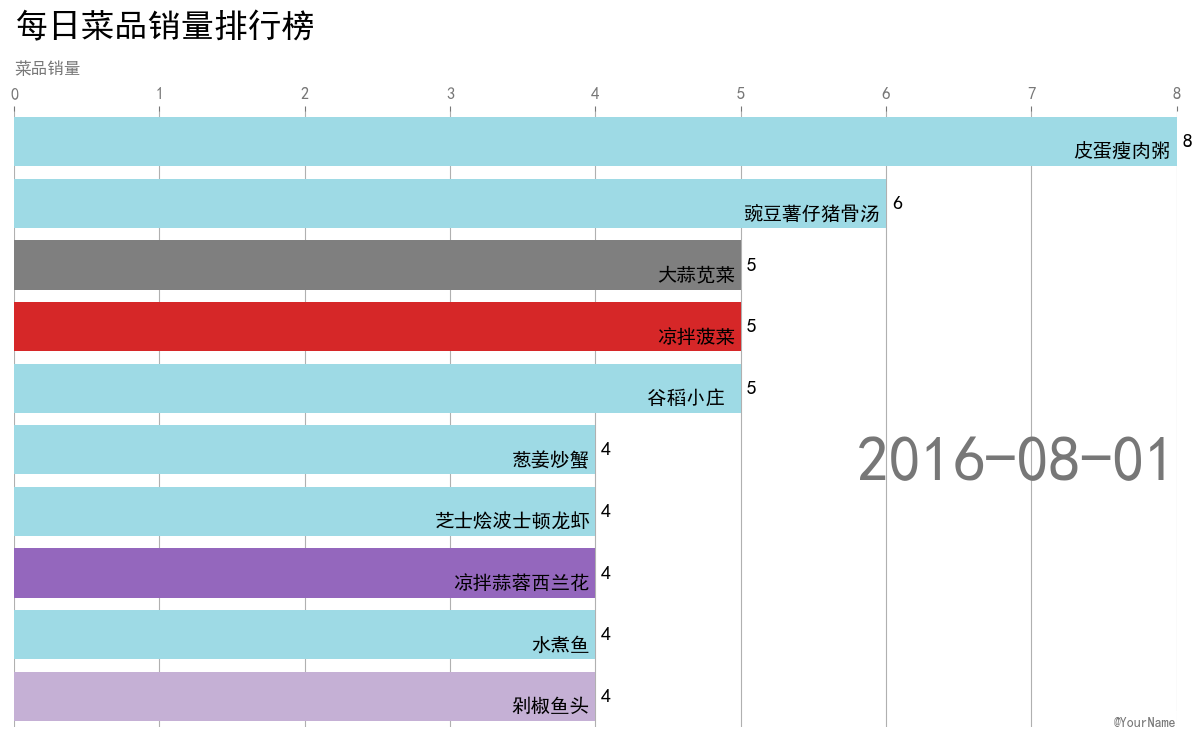

In [29]:
# 2. 数据预处理：每天保留销量前10的菜品
top_n = 10
df_sorted = df.groupby('order_date').apply(
    lambda x: x.nlargest(top_n, 'total_counts').assign(order_date=x.name)
).reset_index(drop=True)

# 3. 获取所有唯一日期和菜品名称
dates = sorted(df_sorted['order_date'].unique())
dish_names = sorted(df_sorted['dishes_name'].unique())

# 定义颜色映射（可以根据实际需求调整）
colors = dict(zip(
    dish_names,
    plt.cm.tab20(range(len(dish_names)))  # 使用matplotlib内置的颜色映射
))

# 4. 初始化绘图参数
fig, ax = plt.subplots(figsize=(15, 8))
def draw_barchart(date):
    # 清除当前图形内容
    ax.clear()
    
    # 获取当前帧对应日期的数据
    data = df_sorted[df_sorted['order_date'] == date]
    
    # 按销量排序并重置索引
    data = data.sort_values(by='total_counts', ascending=True).tail(10).reset_index(drop=True)
    
    # 更新条形图数据
    current_colors = [colors[dish] for dish in data['dishes_name']]
    ax.barh(data['dishes_name'], data['total_counts'], color=current_colors)
    
    # 添加数值标签
    dx = data['total_counts'].max() / 200
    for idx, (value, name) in enumerate(zip(data['total_counts'], data['dishes_name'])):
        # 将菜品名称放在条形图底部
        ax.text(value - dx, idx, name, size=14, weight=600, ha='right', va='top', rotation=0)
        # 数值标签保持不变
        ax.text(value + dx, idx, f'{value:,.0f}', size=14, ha='left', va='center')
    
    # 设置标题和其他样式
    ax.text(1, 0.4, date, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, '菜品销量', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.12, '每日菜品销量排行榜',
            transform=ax.transAxes, size=24, weight=600, ha='left')
    ax.text(1, 0, '@YourName', transform=ax.transAxes, ha='right',
            color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    plt.box(False)

# 创建动画
animator = animation.FuncAnimation(fig, draw_barchart, frames=dates, interval=1000, repeat=False)
HTML(animator.to_jshtml())